In [ ]:
import numpy as np
import sys
sys.path.append('..')
from common.time_layers import RNN
from common.util import preprocess
from common.functions import sigmoid

class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.dh = None, None
    self.stateful = stateful
    
  def set_state(self, h):
    self.h = h

  def reset_state(self):
    self.h = None
    
  def forward(self, xs):
    # N: バッチ数
    # T: 各時系列
    # D: 入力ベクトルの次元数
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape
    
    self.layers = []
    hs = np.empty((N, T, H), dtype='f')
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
      
    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)
    
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape
    
    dxs = np.empty((N, T, D), dtype='f')
    dh = 0
    grads = [0, 0, 0]
    
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      dxs[:, t, :] = dx

      for i, grad in enumerate(grads):
        self.grads[i][...] = grad
      self.dh = dh

      return dxs
  

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 377.75
| epoch 2 | perplexity 251.71
| epoch 3 | perplexity 225.03
| epoch 4 | perplexity 215.19
| epoch 5 | perplexity 206.93
| epoch 6 | perplexity 202.69
| epoch 7 | perplexity 199.29
| epoch 8 | perplexity 197.16
| epoch 9 | perplexity 191.12
| epoch 10 | perplexity 192.96
| epoch 11 | perplexity 188.24
| epoch 12 | perplexity 192.11
| epoch 13 | perplexity 189.68
| epoch 14 | perplexity 190.67
| epoch 15 | perplexity 189.99
| epoch 16 | perplexity 185.83
| epoch 17 | perplexity 183.93
| epoch 18 | perplexity 181.17
| epoch 19 | perplexity 181.31
| epoch 20 | perplexity 182.50
| epoch 21 | perplexity 180.46
| epoch 22 | perplexity 177.07
| epoch 23 | perplexity 173.58
| epoch 24 | perplexity 175.41
| epoch 25 | perplexity 173.71
| epoch 26 | perplexity 173.36
| epoch 27 | perplexity 168.35
| epoch 28 | perplexity 164.88
| epoch 29 | perplexity 161.72
| epoch 30 | perplexity 156.86
| epoch 31 | perplexity 157.91
| epoch 

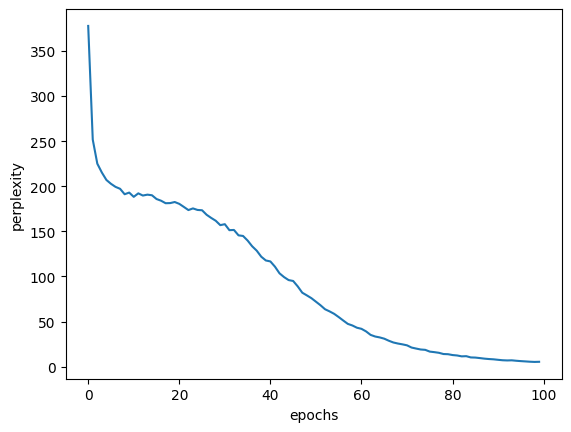

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
